In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

Choosing the right activation function is one of the most crucial architectural decisions in deep learning. This seemingly simple component can determine whether your model converges in hours or days, whether it achieves state-of-the-art performance or fails to learn entirely, and whether it can be deployed efficiently on edge devices or requires expensive GPU clusters.

- **The Mathematical Necessity**

Without activation functions, a neural network, regardless of its depth, reduces to a simple linear transformation. Consider a network with $n$ layers:

$$ \begin{aligned}
f(x) = W_n(W_{n-1}(...(W_1 x))) = W_{combined} \cdot x
\end{aligned} $$

This collapsed linear function cannot learn the complex, non-linear patterns present in real-world data such as images, speech, or natural language. Activation functions introduce the non-linearity that gives neural networks their remarkable approximation capabilities.

- **How Activation Functions Impact Learning Efficiency**

The choice of activation function directly influences the **gradient flow** through your network, which fundamentally determines how efficiently your model learns:

1. **Vanishing Gradients**

   Activation functions like **Sigmoid** and **Tanh** saturate for large input magnitudes, producing gradients that approach zero. During backpropagation, these small gradients are multiplied across layers:

$$ \begin{aligned}
\frac{\partial \mathcal{L}}{\partial W_1} = \frac{\partial \mathcal{L}}{\partial a_n} \cdot \prod_{i=1}^{n} \frac{\partial a_i}{\partial z_i} \cdot \frac{\partial z_i}{\partial a_{i-1}}
\end{aligned} $$

When $\frac{\partial a_i}{\partial z_i}$ (the activation derivative) is consistently small (e.g., Sigmoid's maximum gradient is only 0.25), the product shrinks exponentially. In a 10-layer network with Sigmoid activations, gradients can diminish by a factor of $0.25^{10} \approx 10^{-6}$, effectively preventing early layers from learning.

2. **Dying Neurons**

   **ReLU**, despite its computational efficiency, outputs zero for all negative inputs. If a neuron's weights shift such that it, always receives negative input, its gradient becomes permanently zero—the neuron "dies" and stops contributing to learning. In practice, 10-40% of neurons can die in poorly initialized networks.

4. **Computational Efficiency**

   The difference between a simple operation like $\max(0, x)$ (ReLU) and $x \cdot \sigma(x)$ (SiLU/Swish) may seem negligible, but across billions of operations in modern networks, this translates to measurable differences in training time and energy consumption.

**Real-World Impact: Examples**

| Scenario | Poor Choice | Better Choice | Impact |
|----------|-------------|---------------|--------|
| Deep CNN (50+ layers) | Sigmoid | ReLU / Leaky ReLU | Sigmoid fails to train; ReLU converges in reasonable time |
| Transformer (BERT, GPT) | ReLU | GELU | GELU improves perplexity by 0.5-1.0 points on language modeling |
| Mobile Deployment | SiLU | Hardswish | 15-20% faster inference with minimal accuracy loss |
| Self-Normalizing Network | ReLU + BatchNorm | SELU (no BatchNorm) | Eliminates BatchNorm overhead while maintaining normalization |

**The Learning Dynamics Perspective**

Different activation functions create fundamentally different **loss landscapes**:

- **Sharp activations** (ReLU) create piecewise linear decision boundaries, enabling fast optimization but potentially leading to less smooth functions
- **Smooth activations** (GELU, SiLU, Mish) create continuously differentiable landscapes that may generalize better but require more computation
- **Bounded activations** (Sigmoid, Tanh) compress information into fixed ranges, which can stabilize training but limit expressiveness

**Key Takeaway**

There is no universally "best" activation function. The optimal choice depends on:

1. **Network architecture** (feedforward, convolutional, recurrent, transformer)
2. **Task type** (classification, regression, generation)
3. **Deployment constraints** (server GPU, mobile device, embedded system)
4. **Training dynamics** (gradient flow, convergence speed, stability)

This notebook provides a comprehensive guide to the 15 most widely used activation functions in PyTorch, equipping you with the knowledge to make informed decisions for your specific deep learning applications.

## 1. ReLU (Rectified Linear Unit)

The mathematical equation for ReLu has the following form:

$$ \begin{aligned}
\text{ReLU}(x) = \max(0, x) = 
\begin{cases}
x & \text{if } x > 0 \\
0 & \text{if } x \leq 0
\end{cases}
\end{aligned} $$

**When to Use**
- **Default choice** for hidden layers in most neural networks
- Convolutional Neural Networks (CNNs)
- Deep feedforward networks
- When computational efficiency is important

**Advantages**
- **Computationally efficient**: Simple max operation
- **Sparse activation**: Only activates positive values, leading to sparse representations
- **Mitigates vanishing gradient**: Gradient is 1 for positive values
- **Converges faster** than sigmoid/tanh in practice

**Disadvantages**
- **Dying ReLU problem**: Neurons can become permanently inactive if they output 0
- **Not zero-centered**: Output is always non-negative
- **Unbounded**: Can lead to exploding activations

In [6]:
# Method 1: Using nn.Module
relu = nn.ReLU()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = relu(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Using functional API
output_functional = F.relu(x)
print(f"Functional API: {output_functional}")

# Method 3: In a Sequential model
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5)
)

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([0., 0., 0., 1., 2.])
Functional API: tensor([0., 0., 0., 1., 2.])


## 2. Sigmoid

The Sigmoid activation function takes the following form:

$$ \begin{aligned}
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + e^{-x}}
\end{aligned} $$

**When to Use**
- **Binary classification** output layer
- **Probability estimation** (outputs between 0 and 1)
- Gate mechanisms in LSTMs and GRUs
- Attention mechanisms

**Advantages**
- **Smooth gradient**: Differentiable everywhere
- **Output range [0, 1]**: Interpretable as probability
- **Clear predictions**: Outputs close to 0 or 1 for extreme inputs

**Disadvantages**
- **Vanishing gradient**: Gradient approaches 0 for large |x| (max gradient is 0.25)
- **Not zero-centered**: Can cause zig-zagging gradient updates
- **Computationally expensive**: Involves exponential calculation
- **Saturates**: Kills gradients in deep networks

In [7]:
# Method 1: Using nn.Module
sigmoid = nn.Sigmoid()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = sigmoid(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Using functional API
output_functional = torch.sigmoid(x)
print(f"Functional API: {output_functional}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])
Functional API: tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])


## 3. Tanh (Hyperbolic Tangent)

The Tanh function is give as:


$$ \begin{aligned}
\text{Tanh}(x) = \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} = \frac{2}{1 + e^{-2x}} - 1
\end{aligned} $$

**When to Use**
- **RNN hidden states** (traditional RNNs)
- When **zero-centered** output is needed
- Feature normalization between layers
- Classification problems where negative values are meaningful

**Advantages**
- **Zero-centered**: Output range [-1, 1], helps with gradient flow
- **Stronger gradients** than sigmoid (max gradient is 1)
- **Smooth and differentiable**

**Disadvantages**
- **Vanishing gradient**: Still saturates for large |x|
- **Computationally expensive**: Exponential calculations
- **Slower convergence** than ReLU-based activations

In [8]:
# Method 1: Using nn.Module
tanh = nn.Tanh()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = tanh(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Using functional API
output_functional = torch.tanh(x)
print(f"Functional API: {output_functional}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.9640, -0.7616,  0.0000,  0.7616,  0.9640])
Functional API: tensor([-0.9640, -0.7616,  0.0000,  0.7616,  0.9640])


## 4. Leaky ReLU

The Leaky ReLU activation function takes beside the input an additional small constant $\alpha$ (default: 0.01) and is given by:


$$ \begin{aligned}
\text{LeakyReLU}(x) = \max(0, x) + \alpha \cdot \min(0, x) = 
\begin{cases}
x & \text{if } x > 0 \\
\alpha x & \text{if } x \leq 0
\end{cases}
\end{aligned} $$

**When to Use**
- When **dying ReLU** is a concern
- Deep networks where gradient flow is critical
- As a **drop-in replacement** for ReLU
- GANs (Generative Adversarial Networks)

**Advantages**
- **Prevents dying neurons**: Small gradient for negative inputs
- **Computationally efficient**: Simple operations
- **Enables gradient flow** for all inputs

**Disadvantages**
- **Not zero-centered**
- **Inconsistent results**: Performance depends on choice of α
- **Linear for negative values**: May not capture complex patterns

In [9]:
# Method 1: Using nn.Module with default negative_slope
leaky_relu = nn.LeakyReLU(negative_slope=0.01)
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = leaky_relu(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Custom negative_slope
leaky_relu_02 = nn.LeakyReLU(negative_slope=0.2)
output_02 = leaky_relu_02(x)
print(f"With slope 0.2: {output_02}")

# Method 3: Functional API
output_functional = F.leaky_relu(x, negative_slope=0.01)
print(f"Functional API: {output_functional}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.0200, -0.0100,  0.0000,  1.0000,  2.0000])
With slope 0.2: tensor([-0.4000, -0.2000,  0.0000,  1.0000,  2.0000])
Functional API: tensor([-0.0200, -0.0100,  0.0000,  1.0000,  2.0000])


## 5. PReLU (Parametric ReLU)

The PReLU is similar to the Leaky ReLU, but now the additional parameter is a **learnable parameter** and it is denoted by $a$:


$$ \begin{aligned}
\text{PReLU}(x) = \max(0, x) + a \cdot \min(0, x) = 
\begin{cases}
x & \text{if } x > 0 \\
a \cdot x & \text{if } x \leq 0
\end{cases}
\end{aligned} $$


**When to Use**
- When you want the network to **learn optimal slope**
- Image classification tasks
- When Leaky ReLU's fixed slope seems suboptimal
- CNNs where different channels may need different activations

**Advantages**
- **Adaptive**: Learns optimal negative slope during training
- **Per-channel learning**: Can have different slopes per channel
- **Prevents dying neurons**

**Disadvantages**
- **Additional parameters**: Increases model complexity slightly
- **Risk of overfitting** on small datasets
- **May learn inappropriate values** without proper regularization


In [10]:
# Method 1: Single learnable parameter for all channels
prelu = nn.PReLU()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = prelu(x)
print(f"Input:  {x}")
print(f"Output: {output}")
print(f"Learnable parameter a: {prelu.weight}")

# Method 2: Separate parameter per channel
prelu_channels = nn.PReLU(num_parameters=3)  # For 3 channels
x_channels = torch.randn(1, 3, 4, 4)  # Batch, Channels, H, W
output_channels = prelu_channels(x_channels)
print(f"\nPer-channel parameters: {prelu_channels.weight}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.5000, -0.2500,  0.0000,  1.0000,  2.0000],
       grad_fn=<PreluKernelBackward0>)
Learnable parameter a: Parameter containing:
tensor([0.2500], requires_grad=True)

Per-channel parameters: Parameter containing:
tensor([0.2500, 0.2500, 0.2500], requires_grad=True)


## 6. ELU (Exponential Linear Unit)

The ELU has the following mathematical form:


$$ \begin{aligned}
\text{ELU}(x) = \max(0, x) + \min(0, \alpha (e^{x} - 1)) = 
\begin{cases}
x & \text{if } x > 0 \\
\alpha (e^{x} - 1) & \text{if } x \leq 0
\end{cases}
\end{aligned} $$

where $\alpha$ is typically 1.0.

**When to Use**
- Deep networks requiring **faster convergence**
- When **zero-centered activations** improve performance
- As an alternative to ReLU in CNNs
- Autoencoders and generative models

**Advantages**
- **Smooth negative values**: Soft saturation for negative inputs
- **Near zero-centered**: Mean activations closer to zero
- **No dying neurons**: Always has gradient
- **Noise robust**: Saturates for large negative values

**Disadvantages**
- **Computationally expensive**: Exponential calculation for negative values
- **Not fully zero-centered**
- **Saturates**: Can still have vanishing gradient for very negative x

In [11]:
# Method 1: Using nn.Module
elu = nn.ELU(alpha=1.0)
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = elu(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Custom alpha
elu_custom = nn.ELU(alpha=0.5)
output_custom = elu_custom(x)
print(f"With alpha=0.5: {output_custom}")

# Method 3: Functional API
output_functional = F.elu(x, alpha=1.0)
print(f"Functional API: {output_functional}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.8647, -0.6321,  0.0000,  1.0000,  2.0000])
With alpha=0.5: tensor([-0.4323, -0.3161,  0.0000,  1.0000,  2.0000])
Functional API: tensor([-0.8647, -0.6321,  0.0000,  1.0000,  2.0000])


## 7. SELU (Scaled Exponential Linear Unit)

SELU is given as follows:

$$ \begin{aligned}
\text{SELU}(x) = \lambda 
\begin{cases}
x & \text{if } x > 0 \\
\alpha (e^{x} - 1) & \text{if } x \leq 0
\end{cases}
\end{aligned} $$

where $\lambda \approx 1.0507$ and $\alpha \approx 1.6733$ (fixed values for self-normalization)

**When to Use**
- **Self-normalizing neural networks** (SNNs)
- Deep feedforward networks **without batch normalization**
- When you need **automatic normalization**
- Fully connected architectures

**Advantages**
- **Self-normalizing**: Maintains mean ≈ 0 and variance ≈ 1 across layers
- **No need for batch normalization** in many cases
- **Prevents vanishing/exploding gradients**
- **Strong regularization effect**

**Disadvantages**
- **Specific requirements**: Needs proper weight initialization (lecun_normal)
- **Only works with AlphaDropout**, not standard dropout
- **Best for fully connected networks**: Less effective with CNNs/RNNs
- **Fixed parameters**: Cannot be tuned

In [12]:
# Method 1: Using nn.Module
selu = nn.SELU()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = selu(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Functional API
output_functional = F.selu(x)
print(f"Functional API: {output_functional}")

# Note: SELU works best with specific initialization
# Use nn.init.kaiming_normal_ with mode='fan_in' and nonlinearity='linear'
# Or lecun_normal initialization

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-1.5202, -1.1113,  0.0000,  1.0507,  2.1014])
Functional API: tensor([-1.5202, -1.1113,  0.0000,  1.0507,  2.1014])


## 8. GELU (Gaussian Error Linear Unit)

GELU is given by:


$$ \begin{aligned}
\text{GELU}(x) &= x \cdot \Phi(x) = x \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right] \\
&\approx 0.5 \cdot x \cdot \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715 x^3)\right)\right)
\end{aligned} $$

where $\Phi(x)$ is the CDF of standard normal distribution.


**When to Use**
- **Transformer models** (BERT, GPT, Vision Transformers)
- **NLP tasks**: Standard in modern language models
- When **smooth activation** is preferred over ReLU
- State-of-the-art architectures

**Advantages**
- **Smooth**: Differentiable everywhere
- **Non-monotonic**: Can output negative values for negative inputs
- **State-of-the-art performance** in transformers
- **Stochastic regularization effect**: Probabilistic interpretation

**Disadvantages**
- **Computationally expensive**: More complex than ReLU
- **No sparse activations**: Always produces non-zero outputs
- **Newer**: Less theoretical understanding compared to ReLU

In [13]:
# Method 1: Using nn.Module (exact computation)
gelu = nn.GELU(approximate='none')
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = gelu(x)
print(f"Input:  {x}")
print(f"Output (exact): {output}")

# Method 2: Using tanh approximation (faster)
gelu_approx = nn.GELU(approximate='tanh')
output_approx = gelu_approx(x)
print(f"Output (tanh approx): {output_approx}")

# Method 3: Functional API
output_functional = F.gelu(x)
print(f"Functional API: {output_functional}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output (exact): tensor([-0.0455, -0.1587,  0.0000,  0.8413,  1.9545])
Output (tanh approx): tensor([-0.0454, -0.1588,  0.0000,  0.8412,  1.9546])
Functional API: tensor([-0.0455, -0.1587,  0.0000,  0.8413,  1.9545])


## 9. SiLU / Swish (Sigmoid Linear Unit)

The Sigmoid Linear Unit activation function is given by:


$$ \begin{aligned}
\text{SiLU}(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}
\end{aligned} $$

where $\sigma(x)$ is the sigmoid function.

**When to Use**
- **EfficientNet** and modern CNN architectures
- **Reinforcement learning**
- When ReLU performance plateaus
- Computer vision tasks

**Advantages**
- **Self-gated**: Input multiplied by sigmoid of itself
- **Smooth**: Differentiable everywhere
- **Non-monotonic**: Can learn complex patterns
- **Better gradient flow** than ReLU for negative inputs
- **Discovered by neural architecture search**

**Disadvantages**
- **Computationally expensive**: Requires sigmoid computation
- **Unbounded above**: Can still have large activations
- **Bounded below** at approximately -0.278

In [14]:
# Method 1: Using nn.Module
silu = nn.SiLU()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = silu(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Functional API
output_functional = F.silu(x)
print(f"Functional API: {output_functional}")

# Manual implementation (Swish)
swish_manual = x * torch.sigmoid(x)
print(f"Manual Swish: {swish_manual}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.2384, -0.2689,  0.0000,  0.7311,  1.7616])
Functional API: tensor([-0.2384, -0.2689,  0.0000,  0.7311,  1.7616])
Manual Swish: tensor([-0.2384, -0.2689,  0.0000,  0.7311,  1.7616])


## 10. Mish

The mathematical form of Mish is given by:




$$ \begin{aligned}
\text{Mish}(x) = x \cdot \tanh(\text{softplus}(x)) = x \cdot \tanh(\ln(1 + e^{x}))
\end{aligned} $$

**When to Use**
- **YOLOv4** and object detection
- Computer vision tasks
- When **smooth non-monotonic** activation is desired
- Deep networks with batch normalization

**Advantages**
- **Very smooth**: Infinitely differentiable
- **Self-regularizing**: Non-monotonic nature provides regularization
- **No dying neurons**: Allows small negative outputs
- **Better accuracy** on some benchmarks

**Disadvantages**
- **Computationally expensive**: Multiple operations (softplus, tanh)
- **Memory intensive**: More activations to store
- **Newer**: Less theoretical understanding

In [15]:
# Method 1: Using nn.Module
mish = nn.Mish()
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = mish(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Functional API
output_functional = F.mish(x)
print(f"Functional API: {output_functional}")

# Manual implementation
mish_manual = x * torch.tanh(F.softplus(x))
print(f"Manual Mish: {mish_manual}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.2525, -0.3034,  0.0000,  0.8651,  1.9440])
Functional API: tensor([-0.2525, -0.3034,  0.0000,  0.8651,  1.9440])
Manual Mish: tensor([-0.2525, -0.3034,  0.0000,  0.8651,  1.9440])


## 11. Softmax

The Softmax activation is given by:


$$ \begin{aligned}
\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}
\end{aligned} $$

where $K$ is the number of classes.

**When to Use**
- **Multi-class classification** output layer
- **Probability distribution** over classes
- **Attention mechanisms** (scaled dot-product attention)
- When outputs must sum to 1

**Advantages**
- **Probability interpretation**: Outputs sum to 1
- **Differentiable**: Smooth gradients
- **Emphasizes differences**: Amplifies large values, suppresses small ones

**Disadvantages**
- **Computational cost**: Exponentials and normalization
- **Numerically unstable**: Can overflow; use log-softmax when possible
- **Sensitive to outliers**: One large value dominates
- **Only for output layer**: Not suitable for hidden layers

In [16]:
# Method 1: Using nn.Module
softmax = nn.Softmax(dim=-1)
x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]])
output = softmax(x)
print(f"Input:\n{x}")
print(f"Output:\n{output}")
print(f"Sum per row: {output.sum(dim=-1)}")

# Method 2: Functional API
output_functional = F.softmax(x, dim=-1)
print(f"\nFunctional API:\n{output_functional}")

Input:
tensor([[1., 2., 3.],
        [1., 1., 1.]])
Output:
tensor([[0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])
Sum per row: tensor([1., 1.])

Functional API:
tensor([[0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])


## 12. Softplus

Softplus is given by:




$$ \begin{aligned}
\text{Softplus}(x) = \frac{1}{\beta} \ln(1 + e^{\beta x})
\end{aligned} $$

where $\beta$ controls smoothness (default: 1).



**When to Use**
- When output must be **strictly positive**
- **Variance estimation** in VAEs
- As a **smooth approximation to ReLU**
- Probabilistic models requiring positive parameters

**Advantages**
- **Smooth ReLU approximation**: Differentiable everywhere
- **Always positive**: Output > 0
- **No dead neurons**: Gradient is always non-zero
- **Controllable smoothness** via beta parameter

**Disadvantages**
- **Computationally expensive**: Exponential and log operations
- **Not zero-centered**
- **Slower** than ReLU

In [18]:
# Method 1: Using nn.Module
softplus = nn.Softplus(beta=1, threshold=20)
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = softplus(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Different beta values
softplus_beta5 = nn.Softplus(beta=5)
output_beta5 = softplus_beta5(x)
print(f"With beta=5: {output_beta5}")

# Method 3: Functional API
output_functional = F.softplus(x, beta=1)
print(f"Functional API: {output_functional}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([0.1269, 0.3133, 0.6931, 1.3133, 2.1269])
With beta=5: tensor([9.0798e-06, 1.3431e-03, 1.3863e-01, 1.0013e+00, 2.0000e+00])
Functional API: tensor([0.1269, 0.3133, 0.6931, 1.3133, 2.1269])


## 13. Hardswish

The Hardswish activation is given by:




$$ \begin{aligned}
\text{Hardswish}(x) = 
\begin{cases}
0 & \text{if } x \leq -3 \\
x & \text{if } x \geq 3 \\
x \cdot \frac{x + 3}{6} & \text{otherwise}
\end{cases}
\end{aligned} $$

**When to Use**
- **MobileNetV3** and efficient mobile architectures
- **Edge devices** with limited compute
- When you need **SiLU-like behavior** with less computation
- Quantization-friendly networks

**Advantages**
- **Efficient**: Piecewise linear, no exponentials
- **Approximates Swish**: Similar behavior to SiLU
- **Quantization-friendly**: Better for integer arithmetic
- **Fast on mobile/edge**: Designed for efficiency

**Disadvantages**
- **Not smooth**: Has corners at x = -3 and x = 3
- **Less accurate** than SiLU/Swish
- **Fixed boundaries**: Cannot adjust the transition points

In [24]:
# Method 1: Using nn.Module
hardswish = nn.Hardswish()
x = torch.tensor([-4.0, -3.0, -1.0, 0.0, 1.0, 3.0, 4.0])
output = hardswish(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Functional API
output_functional = F.hardswish(x)
print(f"Functional API: {output_functional}")

# Compare with SiLU/Swish
silu_output = F.silu(x)
print(f"SiLU (comparison): {silu_output}")

Input:  tensor([-4., -3., -1.,  0.,  1.,  3.,  4.])
Output: tensor([-0.0000, -0.0000, -0.3333,  0.0000,  0.6667,  3.0000,  4.0000])
Functional API: tensor([-0.0000, -0.0000, -0.3333,  0.0000,  0.6667,  3.0000,  4.0000])
SiLU (comparison): tensor([-0.0719, -0.1423, -0.2689,  0.0000,  0.7311,  2.8577,  3.9281])


## 14. ReLU6

ReLU6 is given by:




$$ \begin{aligned}
\text{ReLU6}(x) = \min(\max(0, x), 6) = 
\begin{cases}
0 & \text{if } x \leq 0 \\
x & \text{if } 0 < x < 6 \\
6 & \text{if } x \geq 6
\end{cases}
\end{aligned} $$


**When to Use**
- **MobileNet** architectures
- **Quantized neural networks**
- Mobile and embedded devices
- When bounded activations are preferred

**Advantages**
- **Bounded output**: Prevents exploding activations
- **Quantization-friendly**: Fixed range [0, 6] fits well in fixed-point
- **Computationally simple**: Just clipping operations
- **Mobile-optimized**: Designed for efficient inference

**Disadvantages**
- **Saturation**: Zero gradient for x > 6
- **Dying ReLU problem** still exists
- **Information loss**: Clips large activations

In [21]:
# Method 1: Using nn.Module
relu6 = nn.ReLU6()
x = torch.tensor([-2.0, 0.0, 3.0, 6.0, 10.0])
output = relu6(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Functional API
output_functional = F.relu6(x)
print(f"Functional API: {output_functional}")

# Compare with ReLU
relu_output = F.relu(x)
print(f"ReLU (comparison): {relu_output}")

Input:  tensor([-2.,  0.,  3.,  6., 10.])
Output: tensor([0., 0., 3., 6., 6.])
Functional API: tensor([0., 0., 3., 6., 6.])
ReLU (comparison): tensor([ 0.,  0.,  3.,  6., 10.])


## 15. CELU (Continuously Differentiable ELU)

CELU is defined as:




$$ \begin{aligned}
\text{CELU}(x) = \max(0, x) + \min\left(0, \alpha \left(e^{x/\alpha} - 1\right)\right) = 
\begin{cases}
x & \text{if } x > 0 \\
\alpha \left(e^{x/\alpha} - 1\right) & \text{if } x \leq 0
\end{cases}
\end{aligned} $$

where $\alpha$ controls the saturation value for negative inputs.

**When to Use**
- When **continuous second derivative** is important
- Optimization with **second-order methods**
- As an alternative to ELU with better smoothness
- When alpha needs to be adjusted

**Advantages**
- **Continuously differentiable**: Continuously differentiable
- **Controllable saturation**: Alpha adjusts negative saturation
- **Better optimization** landscape than ELU
- **No dying neurons**

**Disadvantages**
- **Computationally expensive**: Exponential calculation
- **Not zero-centered**
- **Less common**: Not as widely used as ELU

In [22]:
# Method 1: Using nn.Module
celu = nn.CELU(alpha=1.0)
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
output = celu(x)
print(f"Input:  {x}")
print(f"Output: {output}")

# Method 2: Different alpha values
celu_alpha2 = nn.CELU(alpha=2.0)
output_alpha2 = celu_alpha2(x)
print(f"With alpha=2.0: {output_alpha2}")

# Method 3: Functional API
output_functional = F.celu(x, alpha=1.0)
print(f"Functional API: {output_functional}")

# Compare with ELU
elu_output = F.elu(x, alpha=1.0)
print(f"ELU (comparison): {elu_output}")

Input:  tensor([-2., -1.,  0.,  1.,  2.])
Output: tensor([-0.8647, -0.6321,  0.0000,  1.0000,  2.0000])
With alpha=2.0: tensor([-1.2642, -0.7869,  0.0000,  1.0000,  2.0000])
Functional API: tensor([-0.8647, -0.6321,  0.0000,  1.0000,  2.0000])
ELU (comparison): tensor([-0.8647, -0.6321,  0.0000,  1.0000,  2.0000])


## Summary Comparison

Let's visualize all 15 activation functions:

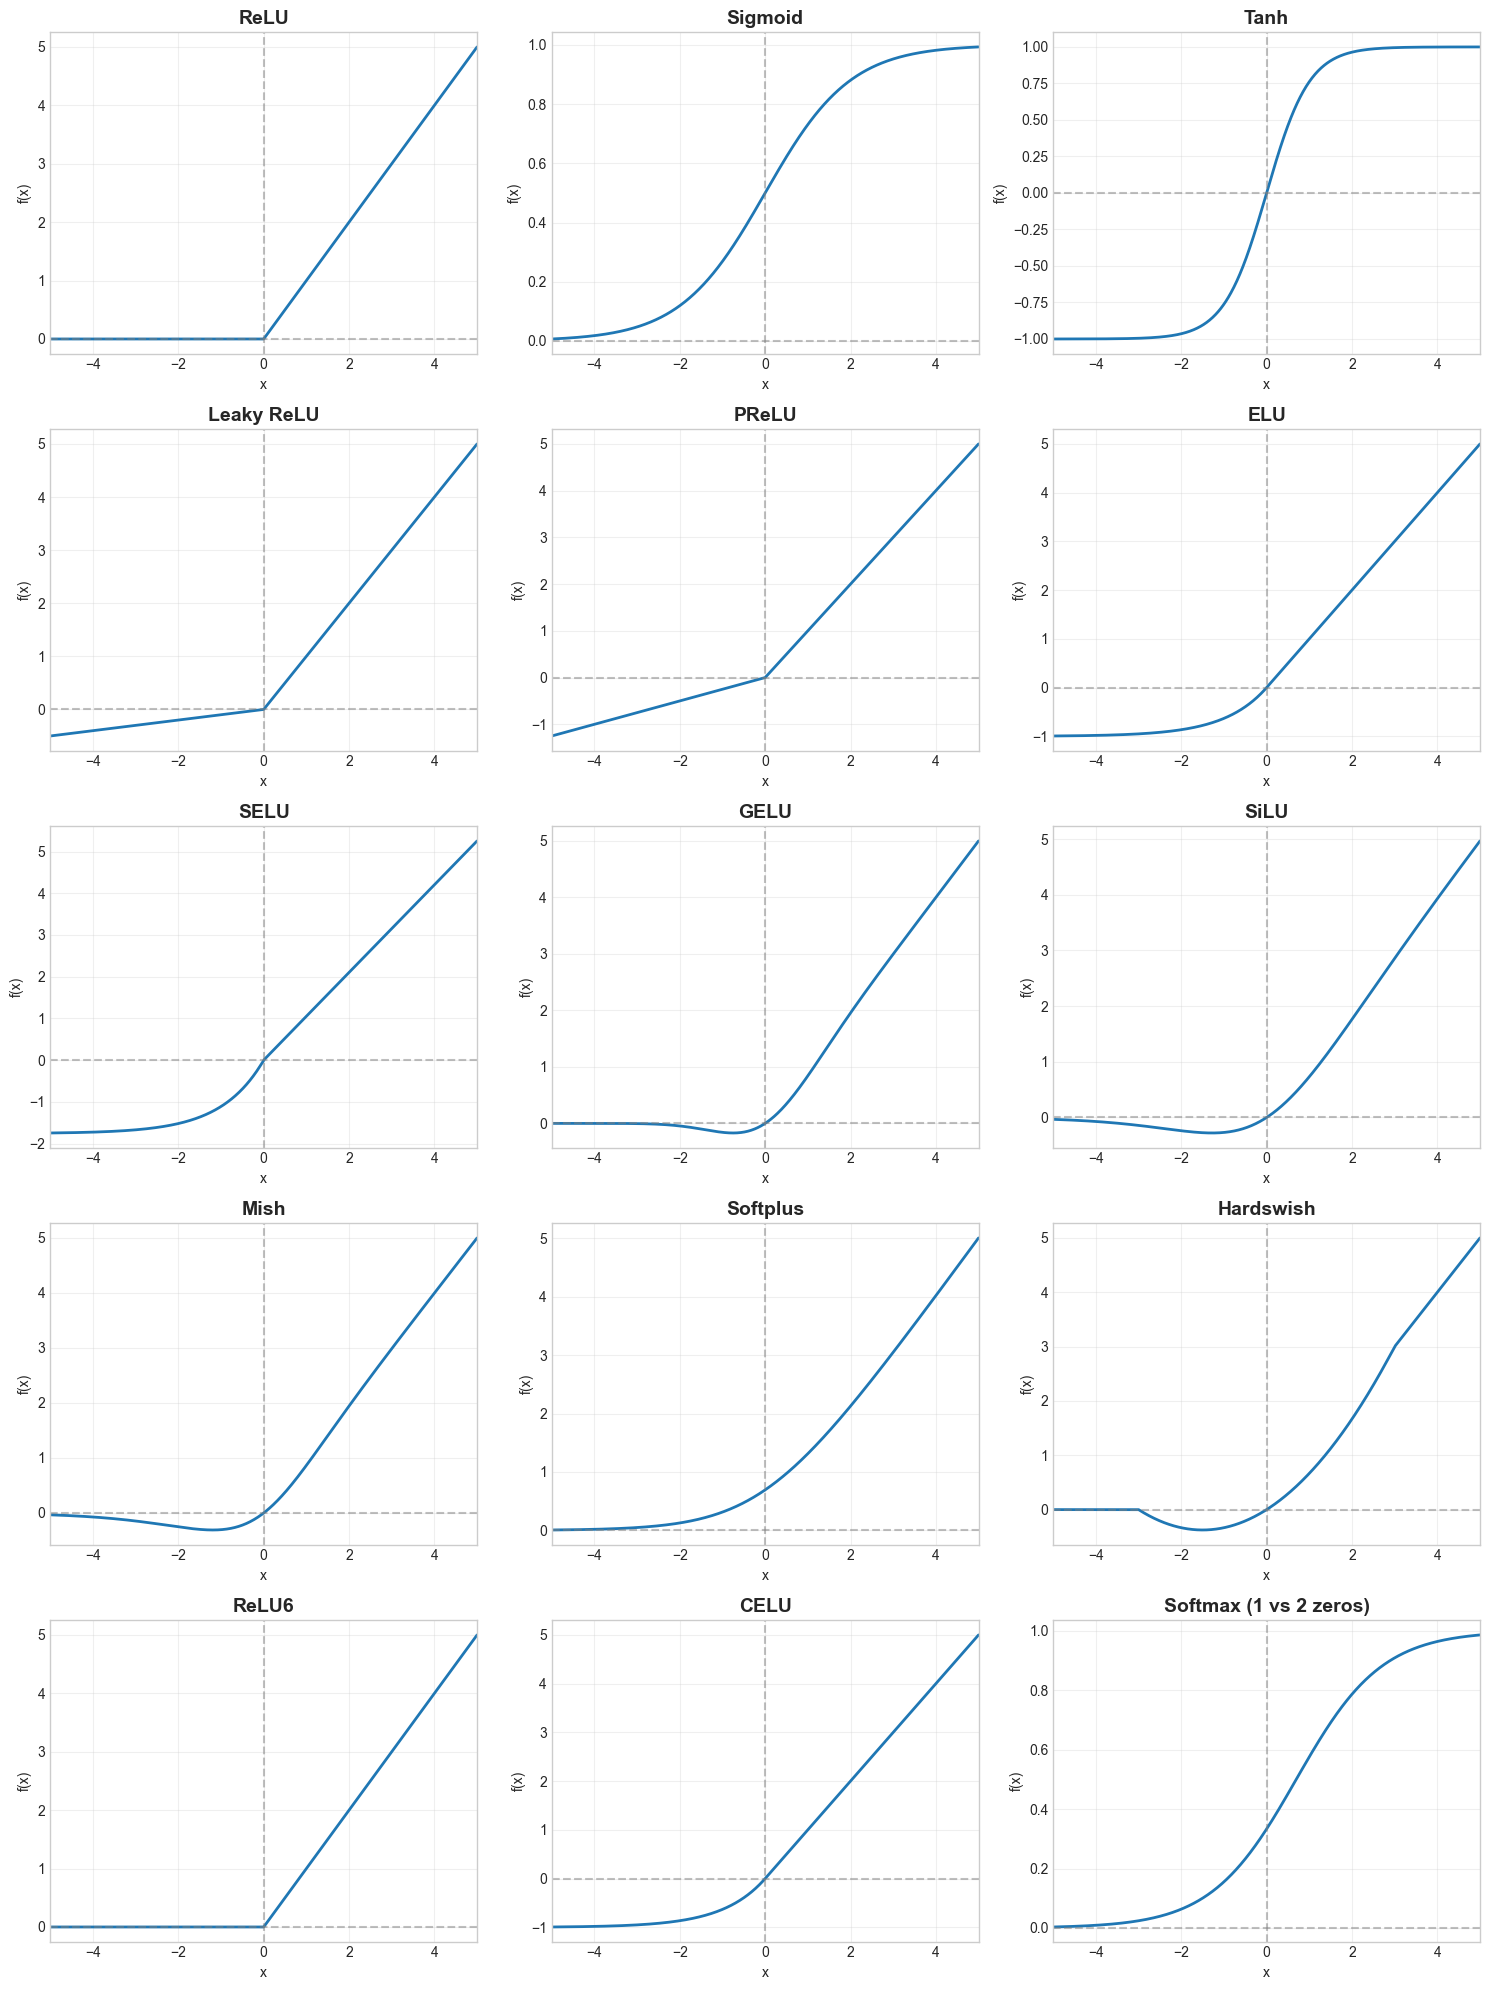

Visualization saved as 'activation_functions.png'


In [25]:
# Create visualization of all activation functions
x = torch.linspace(-5, 5, 1000)

activations = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'Leaky ReLU': nn.LeakyReLU(0.1),
    'PReLU': nn.PReLU(),
    'ELU': nn.ELU(),
    'SELU': nn.SELU(),
    'GELU': nn.GELU(),
    'SiLU': nn.SiLU(),
    'Mish': nn.Mish(),
    'Softplus': nn.Softplus(),
    'Hardswish': nn.Hardswish(),
    'ReLU6': nn.ReLU6(),
    'CELU': nn.CELU(),
}

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

for idx, (name, activation) in enumerate(activations.items()):
    y = activation(x)
    axes[idx].plot(x.numpy(), y.detach().numpy(), linewidth=2)
    axes[idx].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[idx].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[idx].set_title(name, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('f(x)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-5, 5)

# Add Softmax separately (needs 2D input)
x_softmax = torch.stack([x, torch.zeros_like(x), torch.zeros_like(x)], dim=1)
y_softmax = F.softmax(x_softmax, dim=1)[:, 0]
axes[14].plot(x.numpy(), y_softmax.numpy(), linewidth=2)
axes[14].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[14].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[14].set_title('Softmax (1 vs 2 zeros)', fontsize=14, fontweight='bold')
axes[14].set_xlabel('x')
axes[14].set_ylabel('f(x)')
axes[14].grid(True, alpha=0.3)
axes[14].set_xlim(-5, 5)

plt.tight_layout()
plt.savefig('activation_functions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'activation_functions.png'")

## Quick Reference Table


| Activation | Best Use Case | Range | Differentiable | Dying Neurons |
|------------|---------------|-------|----------------|---------------|
| **ReLU** | Default for hidden layers | [0, ∞) | x > 0 | Yes |
| **Sigmoid** | Binary classification output | (0, 1) | Yes | No |
| **Tanh** | RNN hidden states | (-1, 1) | Yes | No |
| **Leaky ReLU** | Deep networks, GANs | (-∞, ∞) | Yes | No |
| **PReLU** | When optimal slope needed | (-∞, ∞) | Yes | No |
| **ELU** | Faster convergence | (-α, ∞) | Yes | No |
| **SELU** | Self-normalizing networks | (-λα, ∞) | Yes | No |
| **GELU** | Transformers, NLP | (-0.17, ∞) | Yes | No |
| **SiLU** | EfficientNet, modern CNNs | (-0.278, ∞) | Yes | No |
| **Mish** | Object detection (YOLO) | (-0.31, ∞) | Yes | No |
| **Softmax** | Multi-class classification | (0, 1) | Yes | No |
| **Softplus** | Positive outputs needed | (0, ∞) | Yes | No |
| **Hardswish** | Mobile networks | (-0.375, ∞) | Piecewise | No |
| **ReLU6** | Mobile/quantized networks | [0, 6] | x ∈ (0,6) | Yes |
| **CELU** | Smooth ELU alternative | (-α, ∞) | Yes | No |

## Conclusion


Choosing the right activation function depends on your specific use case:

1. **Start with ReLU** for most problems
2. **Use GELU** for transformer-based architectures
3. **Use SiLU/Swish** for EfficientNet-style architectures
4. **Use Sigmoid** only for binary classification output
5. **Use Softmax** for multi-class classification output
6. **Consider Leaky ReLU** if you observe dying neurons
7. **Use SELU** for self-normalizing networks (without batch norm)
8. **Use Hardswish/ReLU6** for mobile deployment

The best activation function is often problem-specific, so experimentation is key ;). 